# X-Ray Image Classification Project

Phase 4 Project by Bella Scribner
- Flex/
- Instructor: Morgan Jones
- Bog:
- Date of Review:

# Abstract

# Introduction

## The Business Problem


### Pneumonia
- Who is the business and what is the project about and why?  What is the business looking for?  (what evaluation metrics might be most applicable based on this evaluation?)

[WHO](https://www.who.int/news-room/fact-sheets/detail/pneumonia)
[UNICEF](https://www.unicef.org/stories/childhood-pneumonia-explained)

- "biggest infectious killer of children worldwide"
- "more than 725,000 children under age of 5, including around 190,000 newborns, who are particularly vulnerable to infection"

- bacterial, fungal, or viral (different kinds)
- infection of the lungs which fill up with liquid (alveoli fill with pus and fluid) --> makes breathing painful and limits oxygen intake

- deaths highest in southern Asia + sub-Saharan Africa -- concentrated in the world's poorest countries
- areas without strong health care systems health workers often rely on diagnosing pneumonia by counting # of breath per min.  (few doctors, lack of access to chest x-rays + labs)
    - MAKES IDEA OF THIS PROJECT HARD --> idea is to expand access to health care, make it easier to diagnose, but this project needs an x-ray which then limits who can benefit from it...

- treatment depends on type of --> antibiotics if bacterial (most common), oxygen if available (for all types, but generally only more sever cases)

- chest x-rays are used to diagnos pneumonia based on the inflamation of the lungs
- [RadiologyInfo.org](https://www.radiologyinfo.org/en/info/pneumonia#:~:text=When%20interpreting%20the%20x%2Dray,(fluid%20surrounding%20the%20lungs).)
- look for white spots in the lungs (called infilrates) that id an infection)  also helps determine if have complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs)

### The Business + Project

- [UNICEF Venture Fund](https://www.unicef.org/innovation/venturefund/ai-ds-learning-health-cohort)
- [UNICEF Neural Labs Africa](https://www.unicefventurefund.org/story/neural-labs-using-ai-accelerate-medical-imaging-diagnosis-respiratory-diseases)
- [Neural Labs Africa](https://neurallabs.africa/#)

- In April 2022, UNICEF Venture Fund annouced most recent investments, whic included investing in a company called Neural Labs Africa.  Neural Labs Africa is focused on using deep learning and computer vision to identify diseases in real time.  

- That is the inspiration for this project!  Want to us AI screening to improve patient care. :D 

- This project --> create a model that can be used as a pre-screening for patients, giving a prediction on whether or not the patient has pneumonia.  Based on the seriousness of pneumonia in children, will want to evaluate our model with more than just accuracy -- think precision :)

## The Data Source

- Reproducability!  Make sure to include how to download/access. Also note which versions using in this lab of each python library.

- Data Downloaded from Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

# Data Exploration

## The overview
- From notes of last review --> keep this more contextual and word driven on the front end.  Can talk about results on the back end but want it mostly connected to the header!  
- Don't forget to include target distribution as well as visuals of data in general.



## Detailed exploration

- image sample
- distribution of target

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import numpy as np
np.random.seed(88)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras import optimizers

import tensorflow as tf

#import pandas as pd

In [2]:
# Versions
import sys
import matplotlib
import keras
print('Versions of all libraries:')
print('\tPython | ',sys.version[:5])
print('\tNumpy |', np.__version__)
print('\tMatplotlib | ', matplotlib.__version__)
print('\tSeaborn | ', sns.__version__)
print('\tKeras | ', keras.__version__)
print('\tTensorflow | ', tf.__version__)

Versions of all libraries:
	Python |  3.8.5
	Numpy | 1.18.5
	Matplotlib |  3.3.1
	Seaborn |  0.11.0
	Keras |  2.4.3
	Tensorflow |  2.3.1


In [3]:
# structure of downloaded data
print(os.listdir('./chest_xray'))

# structure of train folder
print(os.listdir('./chest_xray/train'))

['chest_xray', 'test', 'train', 'val', '__MACOSX']
['NORMAL', 'PNEUMONIA']


In [4]:
print(len(os.listdir('./chest_xray/train/NORMAL')))

1081


Looks like we have our data structured such that it is already divided into Train, Validation, and Test segments.  Within those folders the images are stored in two folders based on whether the image is one where pneumonia is present or not.  Let's take a look at the distribution of our target within the train data.

In [4]:
len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
len_total_train = len_normal_train + len_pneu_train

print("There are", len_normal_train, "normal xrays in the training set.")
print("There are", len_pneu_train, "pneumonia xrays in the training set.")
print("There are", len_total_train, "images total in the training set.\n")

print('Target Distributon:')
print('{}% normal'.format(round(len_normal_train/len_total_train * 100, 2)))
print('{}% pneumonia'.format(round(len_pneu_train/len_total_train * 100, 2)))

There are 1341 normal xrays in the training set.
There are 3875 pneumonia xrays in the training set.
There are 5216 images total in the training set.

Target Distributon:
25.71% normal
74.29% pneumonia


In [5]:
len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
len_total_val = len_normal_val + len_pneu_val

len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
len_total_test = len_normal_test + len_pneu_test

print("There are", len_total_val, "images total in the validation set.")
print("There are", len_total_test, "images total in the test set.")

There are 16 images total in the validation set.
There are 624 images total in the test set.


In [6]:
num_images_total = len_total_train + len_total_val + len_total_test
print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

Using 89.07% of data to train
Using 0.27% of data to validate
Using 10.66% of data to test


So it looks like we do not have a very good split between our training and validation data -- having only 16 images / less than 1% of our data to validate with will lead to higher variance in our evaluation metrics when trying to optimize our models.  

Need to move random 5% of train/pneumonia images and 5% of train/normal images into corresponding validation folder to fix this distribution.

In [45]:
# How many images to move over -- 10% of total train data.  
# Note that this will make our imbalance in the train data WORSE
len_total_train * .1  / 2

234.8

In [7]:
# Create lists of file names for train normal + train pneumonia

normal_train_images = [file for file in os.listdir('./chest_xray/train/NORMAL')]
pneu_train_images = [file for file in os.listdir('./chest_xray/train/PNEUMONIA')]

# randomly choose indicies for 5% of data (both normal + pneumonia)
normal_inds = np.random.choice(range(len_normal_train), size=260, replace=False)
pneu_inds = np.random.choice(range(len_pneu_train), size=260, replace=False)

In [8]:
# move chosen images to validatoin folders
## Uncomment cell and run code

#for i in normal_inds:
#    image = normal_train_images[i]
#    origin = './chest_xray/train/NORMAL/' + image
#    destination = './chest_xray/val/NORMAL/' + image
#    shutil.move(origin, destination)
    
#for i in pneu_inds:
#    image = pneu_train_images[i]
#    origin = './chest_xray/train/PNEUMONIA/' + image
#    destination = './chest_xray/val/PNEUMONIA/' + image
#    shutil.move(origin, destination)

In [2]:
len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
len_total_train = len_normal_train + len_pneu_train

len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
len_total_val = len_normal_val + len_pneu_val

len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
len_total_test = len_normal_test + len_pneu_test

print("There are", len_total_train, "images total in the training set.")
print("There are", len_total_val, "images total in the validation set.")
print("There are", len_total_test, "images total in the test set.\n")

num_images_total = len_total_train + len_total_val + len_total_test
print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

There are 4696 images total in the training set.
There are 536 images total in the validation set.
There are 624 images total in the test set.

Using 80.19% of data to train
Using 9.15% of data to validate
Using 10.66% of data to test


In [3]:
print('Target Distributon:')
print('{}% normal'.format(round(len_normal_train/len_total_train * 100, 2)))
print('{}% pneumonia'.format(round(len_pneu_train/len_total_train * 100, 2)))

Target Distributon:
23.02% normal
76.98% pneumonia


That isn't quite 80/10/10 split, but much better than before and will be a good split for this project.  We have a rather unbalanced target distribution.  This might need to be addressed when processing the data in preparation of modeling.

In [4]:
# take a look at some images

train_dir = 'chest_xray/train'
val_dir = 'chest_xray/test'
test_dir = 'chest_xray/val'

# all images will be rescaled by 1./225
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    # resize images down to 150x150
                                                    target_size=(150,150),
                                                    # process in 8 batches
                                                    batch_size=587,
                                                    # target is binary
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150,150),
                                                batch_size=67,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=78,
                                                  class_mode='binary')

Found 4696 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 536 images belonging to 2 classes.


In [5]:
# Create a data sets
## Warning!  This cell might take some time to run
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

for batch in range(8):
    train_i, train_l = next(train_generator)
    train_images.append(train_i)
    train_labels.append(train_l)
    
    val_i, val_l = next(val_generator)
    val_images.append(val_i)
    val_labels.append(val_l)
    
    test_i, test_l = next(test_generator)
    test_images.append(test_i)
    test_labels.append(test_l)

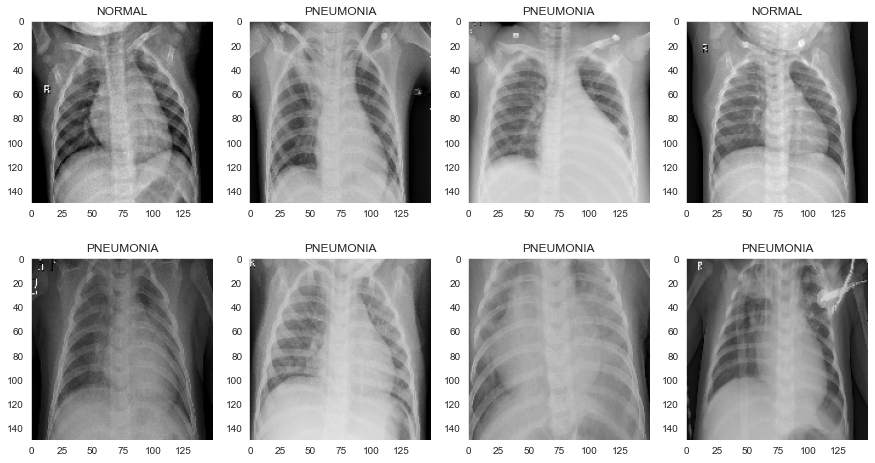

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
classes = list(train_generator.class_indices.keys())

for i in range(8):
    row = i // 4 
    col = i % 4
    ax = axes[row, col]

    ax.imshow(train_images[0][i])
    label = int(train_labels[0][i])
    ax.set_title(classes[label])

# Model Iteration

## Baseline Model

- Baseline model is Dense Neural Network -- then will iterate through a CNN, then optimize that CNN (assuming does better)

- Build Model (Dense model as base line -- convolutonal in further iterations
- Evaluate with loss + accuracy curves

In [10]:
# Baseline model is Dense NN, thus need to reshape data prior to inputting
print('Train images shape:', train_images[0].shape)
print('Train labels shape:', train_labels[0].shape)
print('Validation images shape:', val_images[0].shape)
print('Validation labels shape:', val_labels[0].shape)
print('Test images shape:', test_images[0].shape)
print('Test labels shape:', test_labels[0].shape)

Train images shape: (587, 150, 150, 3)
Train labels shape: (587,)
Validation images shape: (67, 150, 150, 3)
Validation labels shape: (67,)
Test images shape: (78, 150, 150, 3)
Test labels shape: (78,)


In [6]:
# Reshape images
train_img_reshaped = train_images[0].reshape(train_images[0].shape[0],-1)
val_img_reshaped = val_images[0].reshape(val_images[0].shape[0],-1)

print(train_img_reshaped.shape)
print(val_img_reshaped.shape)

(587, 67500)
(67, 67500)


In [7]:
# Reshape Labels
train_labels_reshaped = train_labels[0].reshape(train_labels[0].shape[0],1)
val_labels_reshaped = val_labels[0].reshape(val_labels[0].shape[0],1)

print(train_labels_reshaped.shape)
print(val_labels_reshaped.shape)

(587, 1)
(67, 1)


In [8]:
# Build Baseline Model
baselinemodel = Sequential()

baselinemodel.add(layers.Dense(15, activation='relu', input_shape=(67500,)))
baselinemodel.add(layers.Dense(8, activation='relu'))
baselinemodel.add(layers.Dense(5, activation='relu'))

baselinemodel.add(layers.Dense(1, activation='sigmoid'))

baselinemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                1012515   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,012,694
Trainable params: 1,012,694
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile model
baselinemodel.compile(optimizer=optimizers.RMSprop(learning_rate=1e-8), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [10]:
# Fit Model
history_baseline = baselinemodel.fit(train_img_reshaped,
                                     train_labels_reshaped,
                                     epochs=40,
                                     batch_size=35,
                                     validation_data=(val_img_reshaped, val_labels_reshaped))

Epoch 1/40
17/17 [==============================] - 1s 44ms/step - loss: 0.7039 - accuracy: 0.4020 - recall: 0.2911 - precision: 0.9020 - val_loss: 0.6878 - val_accuracy: 0.5821 - val_recall: 0.3750 - val_precision: 0.8333
Epoch 2/40
17/17 [==============================] - 0s 13ms/step - loss: 0.7022 - accuracy: 0.4140 - recall: 0.3122 - precision: 0.8916 - val_loss: 0.6872 - val_accuracy: 0.5522 - val_recall: 0.3750 - val_precision: 0.7500
Epoch 3/40
17/17 [==============================] - 0s 12ms/step - loss: 0.7008 - accuracy: 0.4378 - recall: 0.3460 - precision: 0.8913 - val_loss: 0.6865 - val_accuracy: 0.5522 - val_recall: 0.3750 - val_precision: 0.7500
Epoch 4/40
17/17 [==============================] - 0s 11ms/step - loss: 0.6993 - accuracy: 0.4566 - recall: 0.3755 - precision: 0.8856 - val_loss: 0.6859 - val_accuracy: 0.5821 - val_recall: 0.4250 - val_precision: 0.7727
Epoch 5/40
17/17 [==============================] - 0s 12ms/step - loss: 0.6978 - accuracy: 0.4787 - recall:

Epoch 38/40
17/17 [==============================] - 0s 13ms/step - loss: 0.6560 - accuracy: 0.7990 - recall: 0.9494 - precision: 0.8272 - val_loss: 0.6743 - val_accuracy: 0.6418 - val_recall: 0.9750 - val_precision: 0.6290
Epoch 39/40
17/17 [==============================] - 0s 16ms/step - loss: 0.6551 - accuracy: 0.8024 - recall: 0.9557 - precision: 0.8266 - val_loss: 0.6742 - val_accuracy: 0.6269 - val_recall: 0.9750 - val_precision: 0.6190
Epoch 40/40
17/17 [==============================] - 0s 16ms/step - loss: 0.6542 - accuracy: 0.8041 - recall: 0.9578 - precision: 0.8270 - val_loss: 0.6742 - val_accuracy: 0.6269 - val_recall: 0.9750 - val_precision: 0.6190


In [11]:
def create_metric_lists(model):
    """
    This function takes in a fitted NN model that included the below metric list when compiled and outputs a list
    of the training metrics and a list of the validation metrics.
    """

    train_metrics = [model.history[i] for i in ['loss', 'accuracy', 'recall', 'precision']]
    val_metrics = [model.history[i] for i in ['val_loss', 'val_accuracy', 'val_recall', 'val_precision']]
    
    return train_metrics, val_metrics

In [12]:
def visualize_metrics(x, train_metrics, val_metrics, model_name):
    """
    -This function takes in an x (representing the number of epochs), a list of the training metrics, 
    and a list of the validation metrics.  These lists should contain a list for each metric used, specifically,
    in order, the model's loss, accuracy, recall, and precision per epoch.  
    -It also takes in a string of the model name used to title the visual.
    -The function outputs four graphs, one for each metric, with the training and validation data on the same axes.
    """
    
    metrics = ['Loss', 'Accuracy', 'Recall', 'Precision']

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,11))
    for i in range(4):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.plot(x,train_metrics[i], label='Train', color='b')
        ax.plot(x, val_metrics[i], label='Validation', color='r')
        ax.set_title(metrics[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metrics[i])
        ax.grid(True)
        ax.legend()
    plt.suptitle('{} Metrics'.format(model_name), fontsize='xx-large')

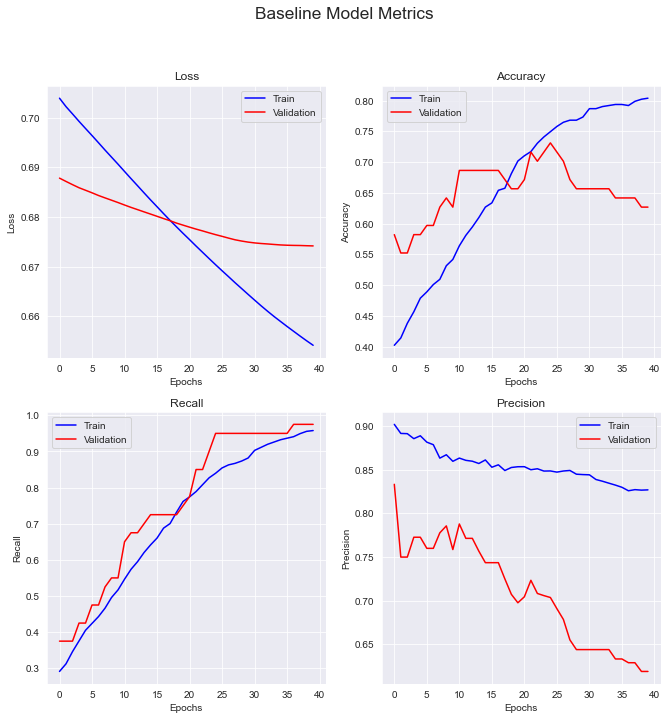

In [13]:
train_metrics, val_metrics = create_metric_lists(history_baseline)
visualize_metrics(range(40), train_metrics, val_metrics, 'Baseline Model')

We can see that our validation results are not great.  Recall is not the best metric to evaluate this model with because of the class imbalance, although due to the nature of our project, we do not want to completely ignore it.  With Recall jumping up to 100% but precision and accuracy of the validation data much lower than the training data, we can safely assume and see that our model is overfitting.

Let's see if we can improve this by (1) using more of the data itself (currently we are only using an eighth of our available training data), (2) using a convolution neural network to help decrease overfitting, and (3) try applying a/some regularization techniques such as dropout to decrease overfitting.

## Same Model Structure as above, but with more data.

First, let's see if we can increase the performance of this baseline model by simply using more data.  This will mean increased time -- we will have to weigh if the time cost is worth the increase we see.  We will try using 75%.

In [15]:
# Reshape 5 more batches and append to already reshaped arrays
for i in range(1,6):

    train_img_reshaped = np.concatenate((train_img_reshaped, train_images[i].reshape(train_images[i].shape[0], -1)))
    val_img_reshaped = np.concatenate((val_img_reshaped, val_images[i].reshape(val_images[i].shape[0], -1)))
    
    train_labels_reshaped = np.concatenate((train_labels_reshaped, train_labels[i].reshape(train_labels[i].shape[0], -1)))
    val_labels_reshaped = np.concatenate((val_labels_reshaped, val_labels[i].reshape(val_labels[i].shape[0], -1)))

In [19]:
print(train_img_reshaped.shape)
print(val_img_reshaped.shape)
print(train_labels_reshaped.shape)
print(val_labels_reshaped.shape)

(3522, 67500)
(402, 67500)
(3522, 1)
(402, 1)


In [16]:
# Rebuild Model
baselinemodel_75 = Sequential()

baselinemodel_75.add(layers.Dense(15, activation='relu', input_shape=(67500,)))
baselinemodel_75.add(layers.Dense(8, activation='relu'))
baselinemodel_75.add(layers.Dense(5, activation='relu'))

baselinemodel_75.add(layers.Dense(1, activation='sigmoid'))

In [17]:
# Compile model
baselinemodel_75.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
# Fit Model
baseline_75_history = baselinemodel.fit(train_img_reshaped,
                                     train_labels_reshaped,
                                     epochs=40,
                                     batch_size=35,
                                     validation_data=(val_img_reshaped, val_labels_reshaped))

Epoch 1/40
101/101 [==============================] - 1s 12ms/step - loss: 0.6549 - accuracy: 0.7760 - recall: 0.9721 - precision: 0.7879 - val_loss: 0.6707 - val_accuracy: 0.6368 - val_recall: 0.9608 - val_precision: 0.6430
Epoch 2/40
101/101 [==============================] - 1s 13ms/step - loss: 0.6509 - accuracy: 0.7785 - recall: 0.9875 - precision: 0.7829 - val_loss: 0.6693 - val_accuracy: 0.6343 - val_recall: 0.9725 - val_precision: 0.6392
Epoch 3/40
101/101 [==============================] - 1s 11ms/step - loss: 0.6475 - accuracy: 0.7777 - recall: 0.9934 - precision: 0.7796 - val_loss: 0.6682 - val_accuracy: 0.6418 - val_recall: 0.9843 - val_precision: 0.6419
Epoch 4/40
101/101 [==============================] - 1s 13ms/step - loss: 0.6443 - accuracy: 0.7765 - recall: 0.9949 - precision: 0.7781 - val_loss: 0.6671 - val_accuracy: 0.6418 - val_recall: 0.9922 - val_precision: 0.6405
Epoch 5/40
101/101 [==============================] - 1s 15ms/step - loss: 0.6412 - accuracy: 0.7765

101/101 [==============================] - 1s 13ms/step - loss: 0.5571 - accuracy: 0.7734 - recall: 1.0000 - precision: 0.7734 - val_loss: 0.6480 - val_accuracy: 0.6343 - val_recall: 1.0000 - val_precision: 0.6343
Epoch 38/40
101/101 [==============================] - 1s 13ms/step - loss: 0.5558 - accuracy: 0.7734 - recall: 1.0000 - precision: 0.7734 - val_loss: 0.6482 - val_accuracy: 0.6343 - val_recall: 1.0000 - val_precision: 0.6343
Epoch 39/40
101/101 [==============================] - 1s 10ms/step - loss: 0.5546 - accuracy: 0.7734 - recall: 1.0000 - precision: 0.7734 - val_loss: 0.6485 - val_accuracy: 0.6343 - val_recall: 1.0000 - val_precision: 0.6343
Epoch 40/40
101/101 [==============================] - 1s 14ms/step - loss: 0.5534 - accuracy: 0.7734 - recall: 1.0000 - precision: 0.7734 - val_loss: 0.6488 - val_accuracy: 0.6343 - val_recall: 1.0000 - val_precision: 0.6343


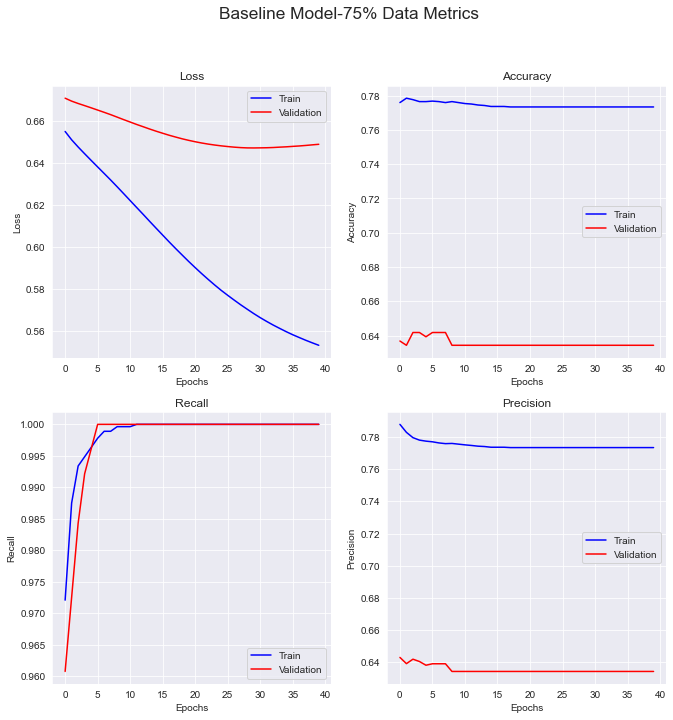

In [18]:
# Visualize Results
train_metrics, val_metrics = create_metric_lists(baseline_75_history)
visualize_metrics(range(40), train_metrics, val_metrics, 'Baseline Model-75% Data')

At a glance, we can see that adding more data actually made our model worse!  Let's move on to convolutional neural network to see if that improves our performance.  Based on the fact that we are clearly overfitting, this seems like the best approach.

## Model 2

- CNN --> CNNs take in the image itself (not reshaped) as the input


In [19]:
# Build the model

cnn = Sequential()

cnn.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(32, (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(20, (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Flatten())

cnn.add(layers.Dense(80, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 20)        5780      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5780)             

In [20]:
# Comiple Model
cnn.compile(loss='binary_crossentropy',
           optimizer='adam',
           metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [21]:
# Train Model **TIME**
cnn_history = cnn.fit(train_generator,
                     epochs=40,
                     validation_data = val_generator)

Epoch 1/40
8/8 [==============================] - 729s 91s/step - loss: 0.5748 - accuracy: 0.7698 - recall_2: 1.0000 - precision_2: 0.7698 - val_loss: 0.7024 - val_accuracy: 0.6250 - val_recall_2: 1.0000 - val_precision_2: 0.6250
Epoch 2/40
8/8 [==============================] - 909s 114s/step - loss: 0.4755 - accuracy: 0.7832 - recall_2: 0.9826 - precision_2: 0.7881 - val_loss: 0.6101 - val_accuracy: 0.6298 - val_recall_2: 1.0000 - val_precision_2: 0.6280
Epoch 3/40
8/8 [==============================] - 988s 124s/step - loss: 0.3499 - accuracy: 0.8445 - recall_2: 0.9765 - precision_2: 0.8455 - val_loss: 0.4772 - val_accuracy: 0.7324 - val_recall_2: 0.9667 - val_precision_2: 0.7100
Epoch 4/40
8/8 [==============================] - 1032s 129s/step - loss: 0.2386 - accuracy: 0.9008 - recall_2: 0.9516 - precision_2: 0.9220 - val_loss: 0.5988 - val_accuracy: 0.7163 - val_recall_2: 0.9821 - val_precision_2: 0.6926
Epoch 5/40
8/8 [==============================] - 992s 124s/step - loss: 0.1

8/8 [==============================] - 890s 111s/step - loss: 0.0220 - accuracy: 0.9930 - recall_2: 0.9953 - precision_2: 0.9956 - val_loss: 1.6726 - val_accuracy: 0.7452 - val_recall_2: 0.9949 - val_precision_2: 0.7119
Epoch 37/40
8/8 [==============================] - 916s 115s/step - loss: 0.0200 - accuracy: 0.9930 - recall_2: 0.9953 - precision_2: 0.9956 - val_loss: 1.5393 - val_accuracy: 0.7564 - val_recall_2: 0.9949 - val_precision_2: 0.7212
Epoch 38/40
8/8 [==============================] - 898s 112s/step - loss: 0.0191 - accuracy: 0.9940 - recall_2: 0.9956 - precision_2: 0.9967 - val_loss: 1.6797 - val_accuracy: 0.7500 - val_recall_2: 0.9949 - val_precision_2: 0.7159
Epoch 39/40
8/8 [==============================] - 928s 116s/step - loss: 0.0171 - accuracy: 0.9951 - recall_2: 0.9975 - precision_2: 0.9961 - val_loss: 1.6795 - val_accuracy: 0.7484 - val_recall_2: 0.9949 - val_precision_2: 0.7145
Epoch 40/40
8/8 [==============================] - 940s 118s/step - loss: 0.0154 - a

In [23]:
train_metrics, val_metrics = create_metric_lists(cnn_history)
visualize_metrics(range(40), train_metrics, val_metrics, 'CNN')

KeyError: 'recall'

## Model 3

- optimize CNN (assuming better than Dense NN)



# Final Model Evaluation

## Recommendations